# A plot says more than 1000 tables: Visualizing missing data with `missingno`

Real-world data sets very rarely are free of missing values. The reasons for this are manifold: A survey item could have just been forgot by a participant but it could also be an offensive question where answers are refused. They can be introduced completely at random by logging errors or systematically, for example, because a condition was not met or a sensor could not record. 

Indipendent of their origin, there are two representations of missing values in numpy/pandas: `None` and `NaN`. `None` is the sentinel value implemented in arrays with dtype object, while `NaN` is a special floating-point value. Pandas was designed to handle both almost interchangeably. 

Even if the machine learning application of your choice may digest data containing missing values, this simply means that they are ignored. Thus, no matter what you are doing, the decision whether to drop/ignore or to impute the missing values has to be made. There are no fixed rules which method is better or even correct, both have advantages and disadvantages. It all comes down to the data set at hand, the understanding of this data set and, by that, the data generating process we have. But consensus is that the extend of missingness, its systematic, and interprertability are the key factors to a sensible decision in this case. Otherwise, you will either throw away a lot of information or introduce bias. 


There is an extensive discussion of the various techniques in the literature, which is out of the scope of this blog post. In this post, I rather want show how to approach a yet unseen data set and how to inspect the missing values with the package [`missingno`](https://github.com/ResidentMario/missingno)<span style="font-size:12px;"><sup>1</sup></span>. A plot says more than 1000 tables, that's why the missingno package is great. It provides four ways to visually summarize the missing values. The plots provide a great overview on the extend, patterns, and inter-relationship of missing data. Before this, I will begin with some preprocessing steps that bring the data in the right shape and make the analysis of missing values easier later.

"There could have been an error in the data collection process, certain measurements are not applicable, or particular fields could have been simply left blank in a survey, for example." Raschka

The analyzed dataset contains listings of homestays in Boston, MA and Seattle, WA on [airbnb.com](airbnb.com). More details and a download link of the data set can be found [here](https://www.kaggle.com/airbnb/boston) and [here](https://www.kaggle.com/airbnb/seattle/data). 

Okay, let's go!

# Making your life easier: Preprocessing

First, let's load the required packages.

In [1]:
# load packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from tabulate import tabulate

# some output options
%matplotlib inline

pd.options.display.max_rows = 30

After downloading the data sets, I am having a look at the file structure:

In [2]:
ls = pd.DataFrame({'boston': listdir("data/boston"), 'seattle': listdir("data/seattle")})

print(tabulate(ls, headers = ls.columns, tablefmt = 'orgtbl'))

|    | boston       | seattle      |
|----+--------------+--------------|
|  0 | calendar.csv | calendar.csv |
|  1 | listings.csv | listings.csv |
|  2 | reviews.csv  | reviews.csv  |


In [3]:
# load data for boston
calendar_b, listings_b, reviews_b = [pd.read_csv('data/boston/' + c) for c in listdir("data/boston")]

In [4]:
# first glimpse at the shapes
print(tabulate(list(map(lambda x: x.shape,[calendar_b, listings_b, reviews_b])), 
               headers = ['rows', 'columns'], 
               showindex = list((ls['boston'] + '_b')),
               tablefmt = 'orgtbl'))

|                |    rows |   columns |
|----------------+---------+-----------|
| calendar.csv_b | 1308890 |         4 |
| listings.csv_b |    3585 |        95 |
| reviews.csv_b  |   68275 |         6 |


`info()` provides more details:

In [5]:
calendar_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [6]:
listings_b.iloc[:, 0:15].info() # truncated to 15 columns for brevity here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 15 columns):
id                       3585 non-null int64
listing_url              3585 non-null object
scrape_id                3585 non-null int64
last_scraped             3585 non-null object
name                     3585 non-null object
summary                  3442 non-null object
space                    2528 non-null object
description              3585 non-null object
experiences_offered      3585 non-null object
neighborhood_overview    2170 non-null object
notes                    1610 non-null object
transit                  2295 non-null object
access                   2096 non-null object
interaction              2031 non-null object
house_rules              2393 non-null object
dtypes: int64(2), object(13)
memory usage: 420.2+ KB


In [7]:
reviews_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
listing_id       68275 non-null int64
id               68275 non-null int64
date             68275 non-null object
reviewer_id      68275 non-null int64
reviewer_name    68275 non-null object
comments         68222 non-null object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


Seems like the interesting stuff is in `listings`. Let's have a closer look! If I do not know a data set at all, I go for a transposed version of `.head()` containing only a single case. Since there are many features in the data set, I again present a glimpse at the first 15 features.

In [8]:
listings_b.iloc[:, 0:15].head(1).transpose() 

0
id                                                              12147973
listing_url                        https://www.airbnb.com/rooms/12147973
scrape_id                                                 20160906204935
last_scraped                                                  2016-09-07
name                                          Sunny Bungalow in the City
summary                Cozy, sunny, family home.  Master bedroom high...
space                  The house has an open and cozy feel at the sam...
description            Cozy, sunny, family home.  Master bedroom high...
experiences_offered                                                 none
neighborhood_overview  Roslindale is quiet, convenient and friendly. ...
notes                                                                NaN
transit                The bus stop is 2 blocks away, and frequent. B...
access                 You will have access to 2 bedrooms, a living r...
interaction                                                          NaN
house_rules            Clean up and treat the home the way you'd like...

In [9]:
listings_b.describe()

id     scrape_id       host_id  host_listings_count  \
count  3.585000e+03  3.585000e+03  3.585000e+03          3585.000000   
mean   8.440875e+06  2.016091e+13  2.492311e+07            58.902371   
std    4.500787e+06  8.516813e-01  2.292781e+07           171.119663   
min    3.353000e+03  2.016091e+13  4.240000e+03             0.000000   
25%    4.679319e+06  2.016091e+13  6.103425e+06             1.000000   
50%    8.577620e+06  2.016091e+13  1.928100e+07             2.000000   
75%    1.278953e+07  2.016091e+13  3.622147e+07             7.000000   
max    1.493346e+07  2.016091e+13  9.385411e+07           749.000000   

       host_total_listings_count  neighbourhood_group_cleansed     latitude  \
count                3585.000000                           0.0  3585.000000   
mean                   58.902371                           NaN    42.340032   
std                   171.119663                           NaN     0.024403   
min                     0.000000                           NaN    42.235942   
25%                     1.000000                           NaN    42.329995   
50%                     2.000000                           NaN    42.345201   
75%                     7.000000                           NaN    42.354685   
max                   749.000000                           NaN    42.389982   

         longitude  accommodates    bathrooms  ...  review_scores_accuracy  \
count  3585.000000   3585.000000  3571.000000  ...             2762.000000   
mean    -71.084818      3.041283     1.221647  ...                9.431571   
std       0.031565      1.778929     0.501487  ...                0.931863   
min     -71.171789      1.000000     0.000000  ...                2.000000   
25%     -71.105083      2.000000     1.000000  ...                9.000000   
50%     -71.078429      2.000000     1.000000  ...               10.000000   
75%     -71.062155      4.000000     1.000000  ...               10.000000   
max     -71.000100     16.000000     6.000000  ...               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                2767.000000            2765.000000   
mean                    9.258041               9.646293   
std                     1.168977               0.762753   
min                     2.000000               2.000000   
25%                     9.000000               9.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  2767.000000             2763.000000   
mean                      9.646549                9.414043   
std                       0.735507                0.903436   
min                       4.000000                2.000000   
25%                       9.000000                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  license  jurisdiction_names  \
count          2764.000000      0.0                 0.0   
mean              9.168234      NaN                 NaN   
std               1.011116      NaN                 NaN   
min               2.000000      NaN                 NaN   
25%               9.000000      NaN                 NaN   
50%               9.000000      NaN                 NaN   
75%              10.000000      NaN                 NaN   
max              10.000000      NaN                 NaN   

       calculated_host_listings_count  reviews_per_month  
count                     3585.000000        2829.000000  
mean                        12.733891           1.970908  
std                         29.415076           2.120561  
min                          1.000000           0.010000  
25%                          1.0000

Before we analyze the missing data, we need to join the data sets first. This requires some preliminary examination and measures.

Does the data of Seattle exhibit the same structure?

In [10]:
# load the Seattle data
calendar_s, listings_s, reviews_s = [pd.read_csv('data/seattle/' + c) for c in listdir("data/seattle")]

In [11]:
print(tabulate(list(map(lambda x: x.shape,[calendar_b, listings_b, reviews_b, calendar_s, listings_s, reviews_s])), 
               headers = ['rows', 'columns'], 
               showindex = list((ls['boston'] + '_b').append(ls['seattle'] + '_s')),
               tablefmt = 'orgtbl'))

|                |    rows |   columns |
|----------------+---------+-----------|
| calendar.csv_b | 1308890 |         4 |
| listings.csv_b |    3585 |        95 |
| reviews.csv_b  |   68275 |         6 |
| calendar.csv_s | 1393570 |         4 |
| listings.csv_s |    3818 |        92 |
| reviews.csv_s  |   84849 |         6 |


As we see, there is a different number of cases. Also, there are three columns in the Boston data set that are not in the Seattle data set. Which ones are missing?

In [12]:
excl_columns = [c for c in listings_b if c not in listings_s]
excl_columns

['access', 'interaction', 'house_rules']

In [13]:
listings_b[excl_columns].head()

access  \
0  You will have access to 2 bedrooms, a living r...   
1  Apt has one more bedroom (which I use) and lar...   
2  I am living in the apartment during your stay,...   
3  The basement has a washer dryer and gym area. ...   
4  You will have access to the front and side por...   

                                         interaction  \
0                                                NaN   
1  If I am at home, I am likely working in my hom...   
2  ABOUT ME: I'm a laid-back, friendly, unmarried...   
3  We do live in the house therefore might be som...   
4  I love my city and really enjoy sharing it wit...   

                                         house_rules  
0  Clean up and treat the home the way you'd like...  
1  Pet friendly but please confirm with me if the...  
2  I encourage you to use my kitchen, cooking and...  
3  - The bathroom and house are shared so please ...  
4  Please no smoking in the house, porch or on th...

This does not seem relevant to the question at hand. Hence, I drop them before joining the data sets.

In [14]:
listings_b = listings_b.drop(excl_columns, axis = 1)

Do some data types differ?

In [15]:
listings_b.loc[:, ~(listings_s.dtypes == listings_b.dtypes)].dtypes

host_listings_count               int64
host_total_listings_count         int64
neighbourhood_group_cleansed    float64
has_availability                float64
jurisdiction_names              float64
dtype: object

In [16]:
listings_s.loc[:, ~(listings_s.dtypes == listings_b.dtypes)].dtypes

host_listings_count             float64
host_total_listings_count       float64
neighbourhood_group_cleansed     object
has_availability                 object
jurisdiction_names               object
dtype: object

In [17]:
listings_b.loc[:, ~(listings_s.dtypes == listings_b.dtypes)].head()

host_listings_count  host_total_listings_count  \
0                    1                          1   
1                    1                          1   
2                    1                          1   
3                    1                          1   
4                    1                          1   

   neighbourhood_group_cleansed  has_availability  jurisdiction_names  
0                           NaN               NaN                 NaN  
1                           NaN               NaN                 NaN  
2                           NaN               NaN                 NaN  
3                           NaN               NaN                 NaN  
4                           NaN               NaN                 NaN

In [18]:
listings_s.loc[:, ~(listings_s.dtypes == listings_b.dtypes)].head()

host_listings_count  host_total_listings_count  \
0                  3.0                        3.0   
1                  6.0                        6.0   
2                  2.0                        2.0   
3                  1.0                        1.0   
4                  2.0                        2.0   

  neighbourhood_group_cleansed has_availability jurisdiction_names  
0                   Queen Anne                t         WASHINGTON  
1                   Queen Anne                t         WASHINGTON  
2                   Queen Anne                t         WASHINGTON  
3                   Queen Anne                t         WASHINGTON  
4                   Queen Anne                t         WASHINGTON

Seems like the floating point numbers (floats) should be integers here. They are quickly converted, though.

In [19]:
listings_s[['host_listings_count', 'host_total_listings_count']] = listings_s[['host_listings_count', 'host_total_listings_count']].astype('Int64')

What's in the remaining features that differ between the data sets?

In [20]:
[print(listings_b[c].value_counts(dropna = False)) for c in ['neighbourhood_group_cleansed', 'has_availability', 'jurisdiction_names']]

NaN    3585
Name: neighbourhood_group_cleansed, dtype: int64
NaN    3585
Name: has_availability, dtype: int64
NaN    3585
Name: jurisdiction_names, dtype: int64


[None, None, None]

In [21]:
[print(listings_s[c].value_counts(dropna = False)) for c in ['neighbourhood_group_cleansed', 'has_availability', 'jurisdiction_names']]

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64
t    3818
Name: has_availability, dtype: int64
WASHINGTON    3818
Name: jurisdiction_names, dtype: int64


[None, None, None]

Since `has_availability` and `jurisdiction_names` is either empty or a constant, we can safely drop both columns.

In [22]:
listings_b, listings_s = map(lambda x: x.drop(['has_availability', 'jurisdiction_names'], axis = 1), [listings_b, listings_s])

# The missingno package

Let's check out missing data with the `missingno` package. 

Since some variables could be missing or constant in one city but perfectly fine in the other city, I join the two data frames before I remove any columns.

In [23]:
# implement indication of city
# since there is already a column named 'city', I add 'dataset' to avoid confusion
listings_b['dataset_city'] = 'Boston'
listings_s['dataset_city'] = 'Seattle'

In [24]:
df = pd.concat([listings_b, listings_s])

Before I check for missing data, I remove every feature that is certainly not related to the research question at hand and is of no predictive use anymore. For example, if you do not plan to join the data set with other data sets, you can safely remove identifiers such as `id`. You may find more variables that are not informative, but this is my selection of variables that can be definitely dropped for this blog post. In the end, it completely depends on your goal.

In [25]:
df = df.drop(['id', 'listing_url', 'scrape_id', 'name', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url'], axis = 1)

Okay, let's go check out `missingno`.

In [26]:
# import missingno package
import missingno as msno

## 1. bar()

`bar()` visualizes the nullity by column.

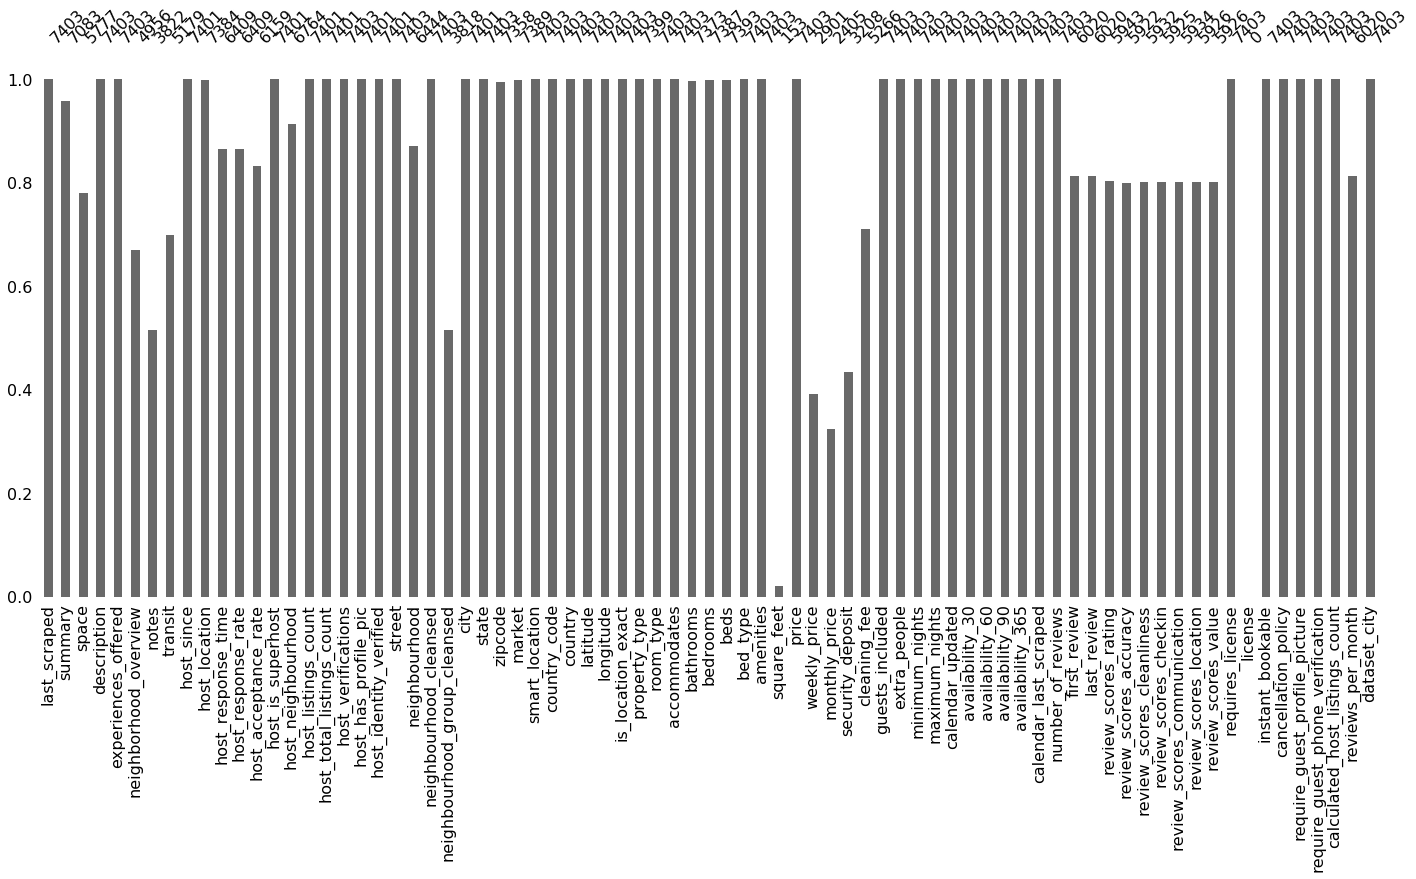

In [27]:
msno.bar(df)

That certainly looks confusing. Of course, a plot including all features makes sense to see what features are completely missing or completely present at first glance. But in all other cases, we first need to thin the data set before we proceed. 

First, drop columns with no valid values.

In [28]:
df = df.dropna(how = 'all', axis = 1)

Drop any duplicate rows (just in case...)

In [29]:
df = df.drop_duplicates()

Next, remove constant features.

In [30]:
from sklearn.feature_selection import VarianceThreshold

nzv = VarianceThreshold(threshold = 0.01) # only columns with more than 1% variance are retained

# since the function digests only numericals and no NaNs, we need to select them
nums = (df.select_dtypes(include=['number'])).dropna(how = 'any', axis = 0)

# apply the selector
nzv.fit(nums)

nums.columns[~nzv.get_support()] # excluded columns

Index([], dtype='object')

No near zero variance columns are in the data set and, thus, no column will be removed in this step. Since we still have 76 columns, analyzing the missing data might be more insightful if we just look at the columns that in fact exhibit missing cases at some points (and it's faster).

In [31]:
# define date frame that contains only columns with at least one missing value
df_miss = df.loc[:, df.isna().any(axis = 0)]

Tabulate proportion of NA per column. The output is again truncated to only include features with more than 2.5% missing values.

In [32]:
truncate = df_miss.isna().mean() > .025
pd.DataFrame({'sum': df_miss.loc[:, truncate].isna().sum(), 'mean': df_miss.loc[:, truncate].isna().mean()}).round(3).sort_values(by = 'mean', ascending = False)

sum   mean
square_feet                   7250  0.979
monthly_price                 4998  0.675
weekly_price                  4502  0.608
security_deposit              4195  0.567
neighbourhood_group_cleansed  3585  0.484
notes                         3581  0.484
neighborhood_overview         2447  0.331
transit                       2224  0.300
cleaning_fee                  2137  0.289
space                         1626  0.220
review_scores_checkin         1478  0.200
review_scores_location        1477  0.200
review_scores_value           1477  0.200
review_scores_accuracy        1481  0.200
review_scores_cleanliness     1471  0.199
review_scores_communication   1469  0.198
review_scores_rating          1460  0.197
reviews_per_month             1383  0.187
last_review                   1383  0.187
first_review                  1383  0.187
host_acceptance_rate          1244  0.168
host_response_rate             994  0.134
host_response_time             994  0.134
neighbourhood                  959  0.130
host_neighbourhood             639  0.086
summary                        320  0.043

`square_feet` seems to be a rotten apple here. It could hold the same information as `space`?

In [33]:
print(df[['square_feet', 'space']].dtypes)

square_feet    float64
space           object
dtype: object


Nope, space is text!

In [34]:
df['space'].head()

0    The house has an open and cozy feel at the sam...
1    Small but cozy and quite room with a full size...
2    Come stay with a friendly, middle-aged guy in ...
3    Most places you find in Boston are small howev...
4    Clean, attractive, private room, one block fro...
Name: space, dtype: object

Nope, apparently not. Since `square_feet` is missing in 97.9 % of the cases, it adds no predictive value. Removing a feature that has almost no valid values is always rather safe because the potential for introducing bias is low and not much information is discarded.

In [35]:
df, df_miss = map(lambda x: x.drop('square_feet', axis = 1), [df, df_miss])

Plot again:

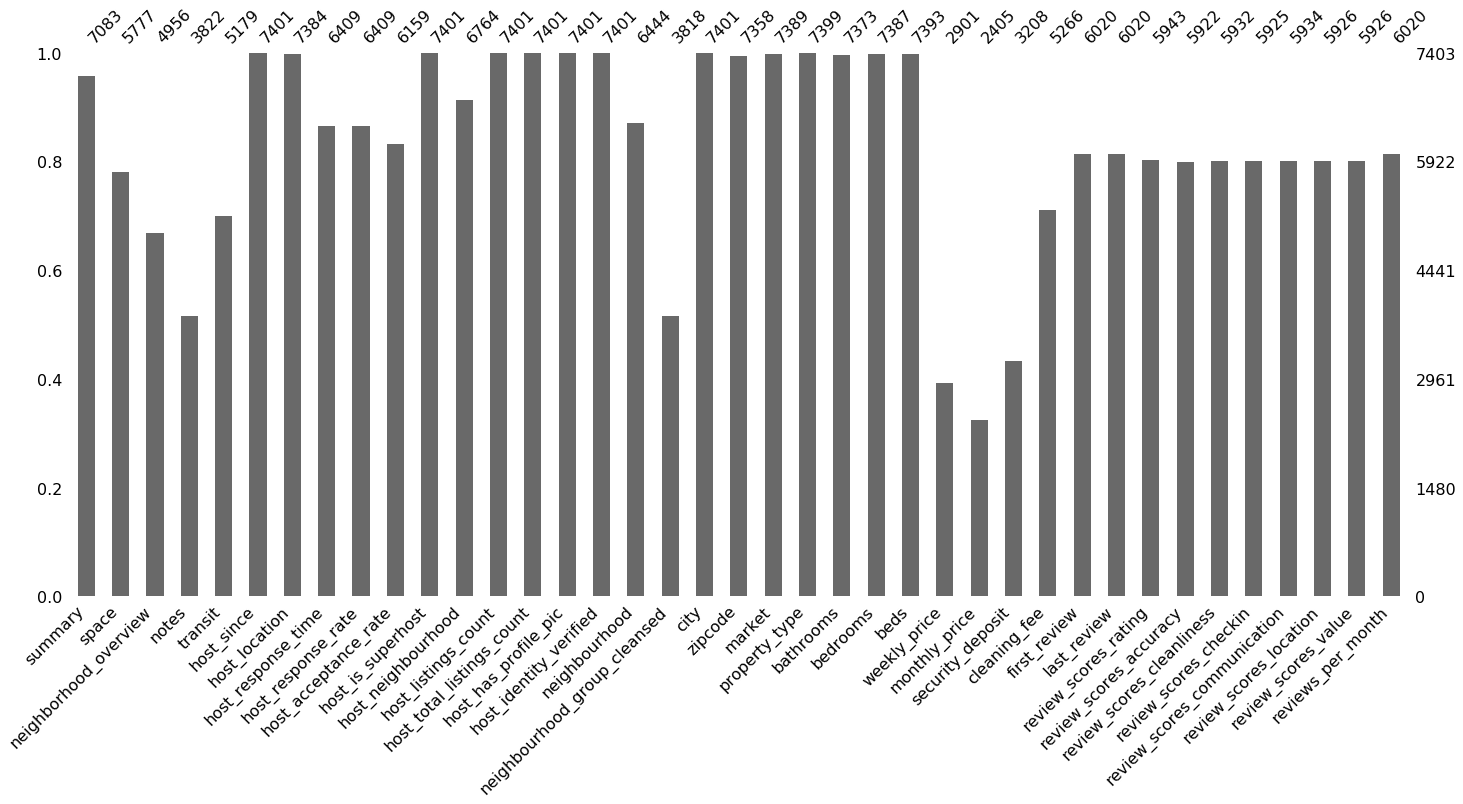

In [36]:
msno.bar(df_miss)

Way better!

## 2. matrix()

`matrix()` provides a nullity matrix to examine missing data by row. It is ideal to visually check whether the missing values follow any pattern. The spark line on the far right marks the most and least complete case.

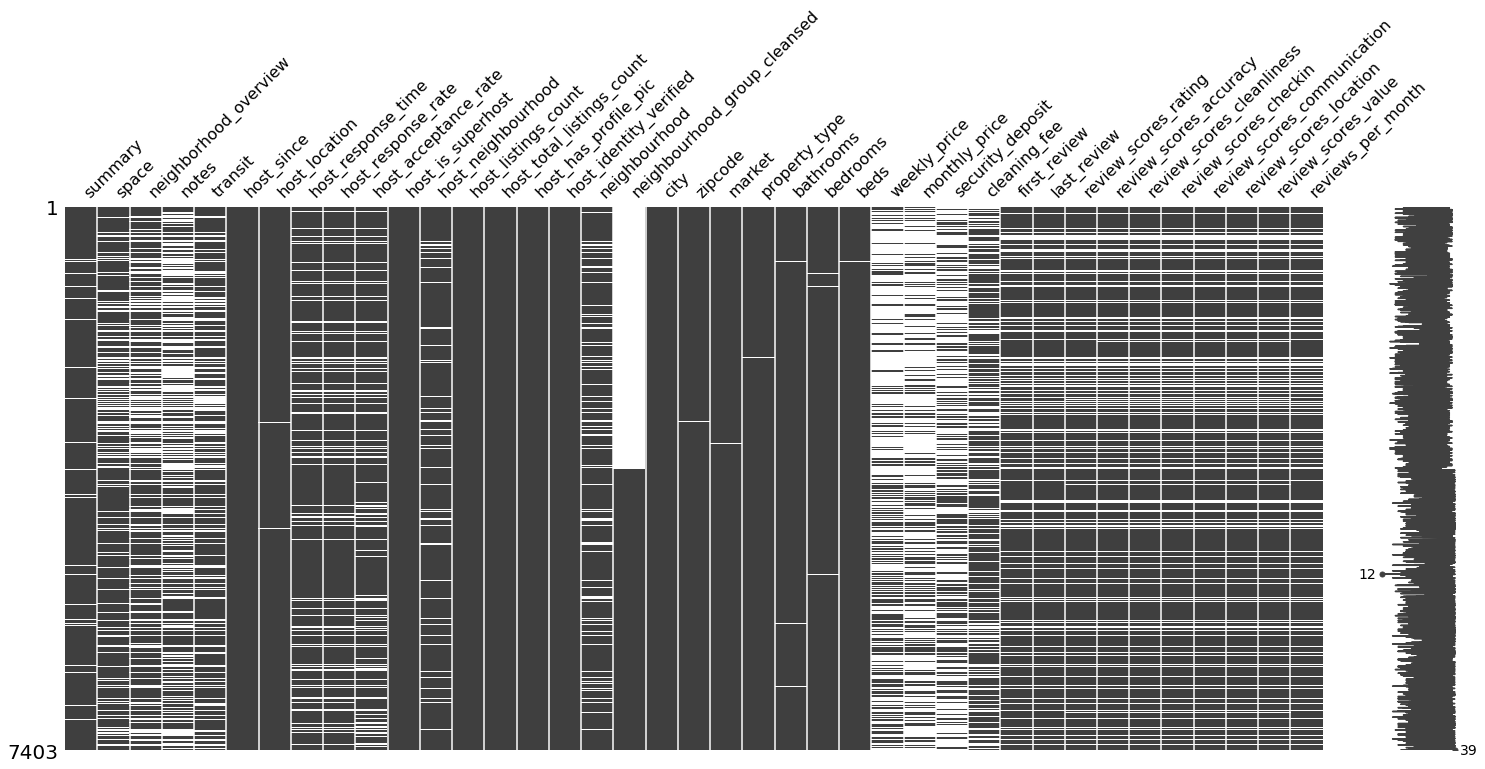

In [37]:
msno.matrix(df_miss)

`sort = 'descending'` sorts the cases by their completeness.

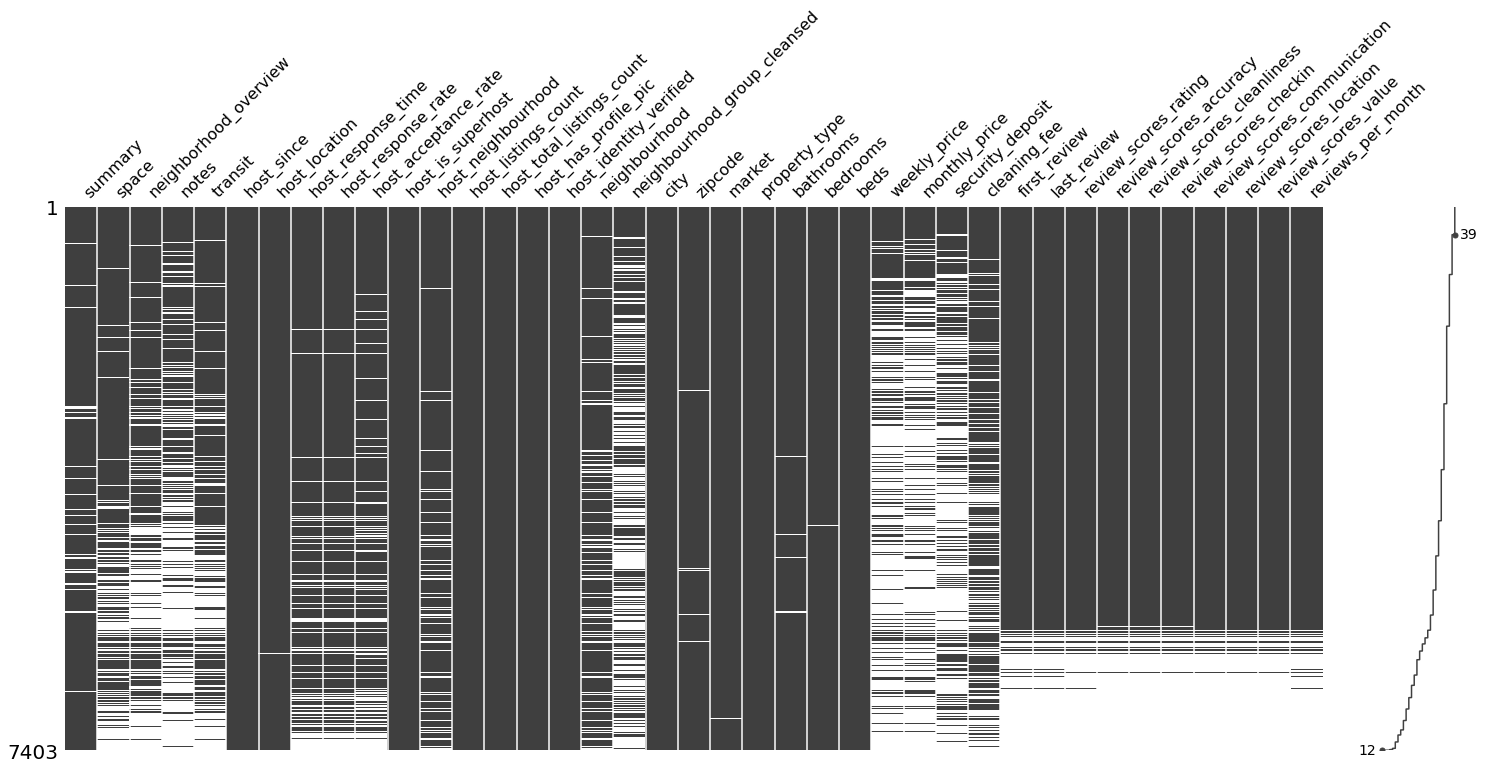

In [38]:
msno.matrix(df_miss, sort = 'descending')

## 3. heatmap()

The `heatmap()` function visualizes how strongly the presence or absence of one variable does affect the presence of another. The visualized nullity correlation ranges from -1 (if one variable is present the other is certainly not present; marked in red) to 0 (presence of one variable has no effect on the presence of the other) to 1 (if one variable is present the other is certainly also present; marked in blue). Only the bottom half is presented because correlations are symmetric relations, i.e. the correlation between *A* and *B* is the same as between *B* and *A*. Variables with no missing values or no present values are removed from this visualization. Why? Because constant variables show no variance and, therefore, no matter what value another variable exhibits, there is also a present or always a missing value in the variable of question. There is also no diagonal because the correlation of a variable with itself does not make sense in this context: If the variable is present, it is present...yeah, right...

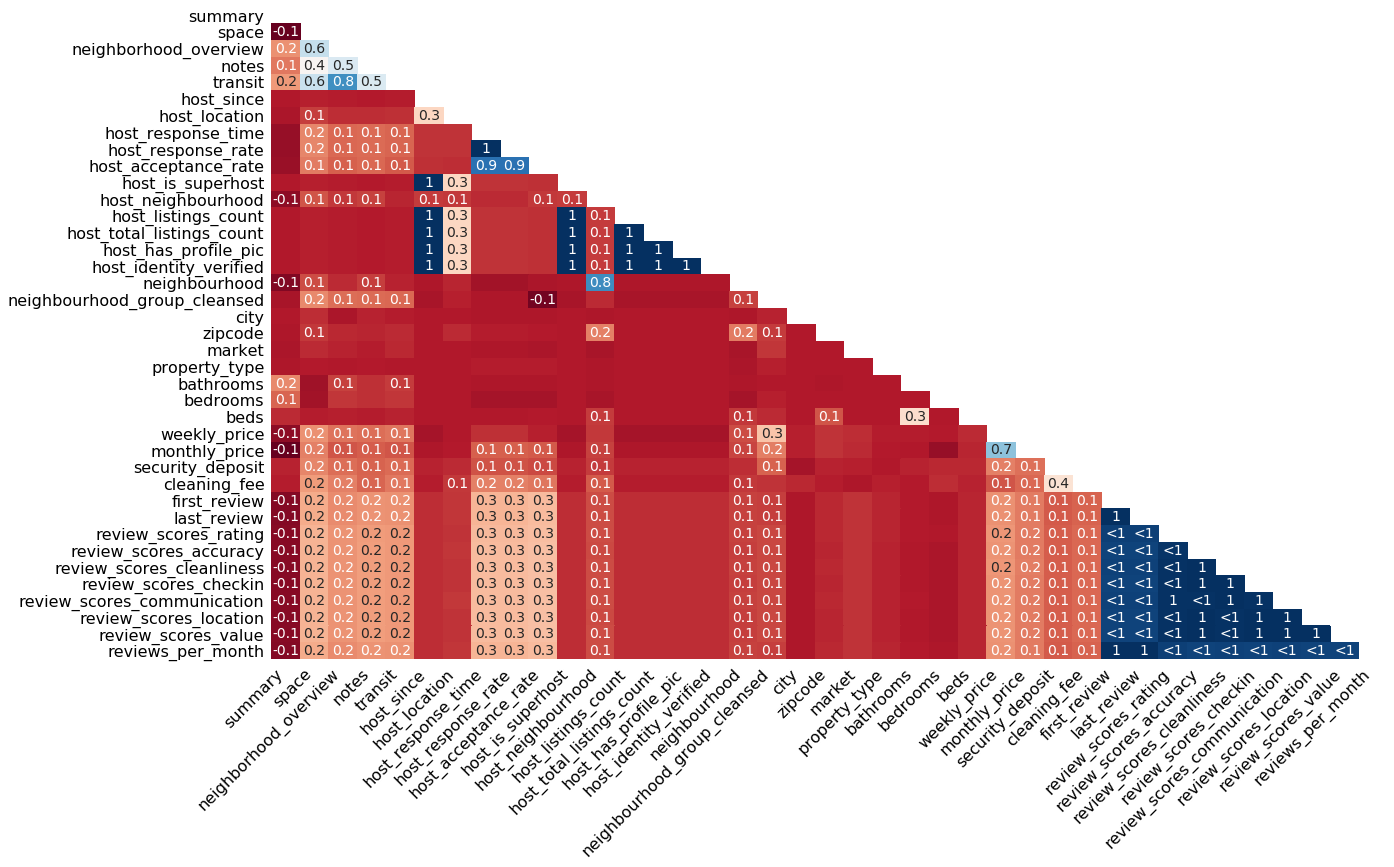

In [52]:
msno.heatmap(df)

You can pick another color scheme by setting the *cmap* parameter. I recommend this not only for aesthetical reasons, but also for clarity. The default argument is `RdBu`, which is a diverging color scale (more info [here](https://matplotlib.org/users/colormaps.html)). In the package's source code, there are actually two parameters, `vmin` and `vmax` to adjust the limits of this scale, which are set to `vmin = -1` and `vmax = 1` by default. However, these parameters do not seem to work anymore. Thus, the center of this diverging scale is adapted from the data at hand. If there are no strong negative correlations, the center of the color scale represents actually moderate, positive correlations. This can be avoided with some tinkering, adding an artifical strong negative correlation, or – a bit quick and dirty – by going for a sequential scale like `Blues`. For brevity, I go with the last solution here:

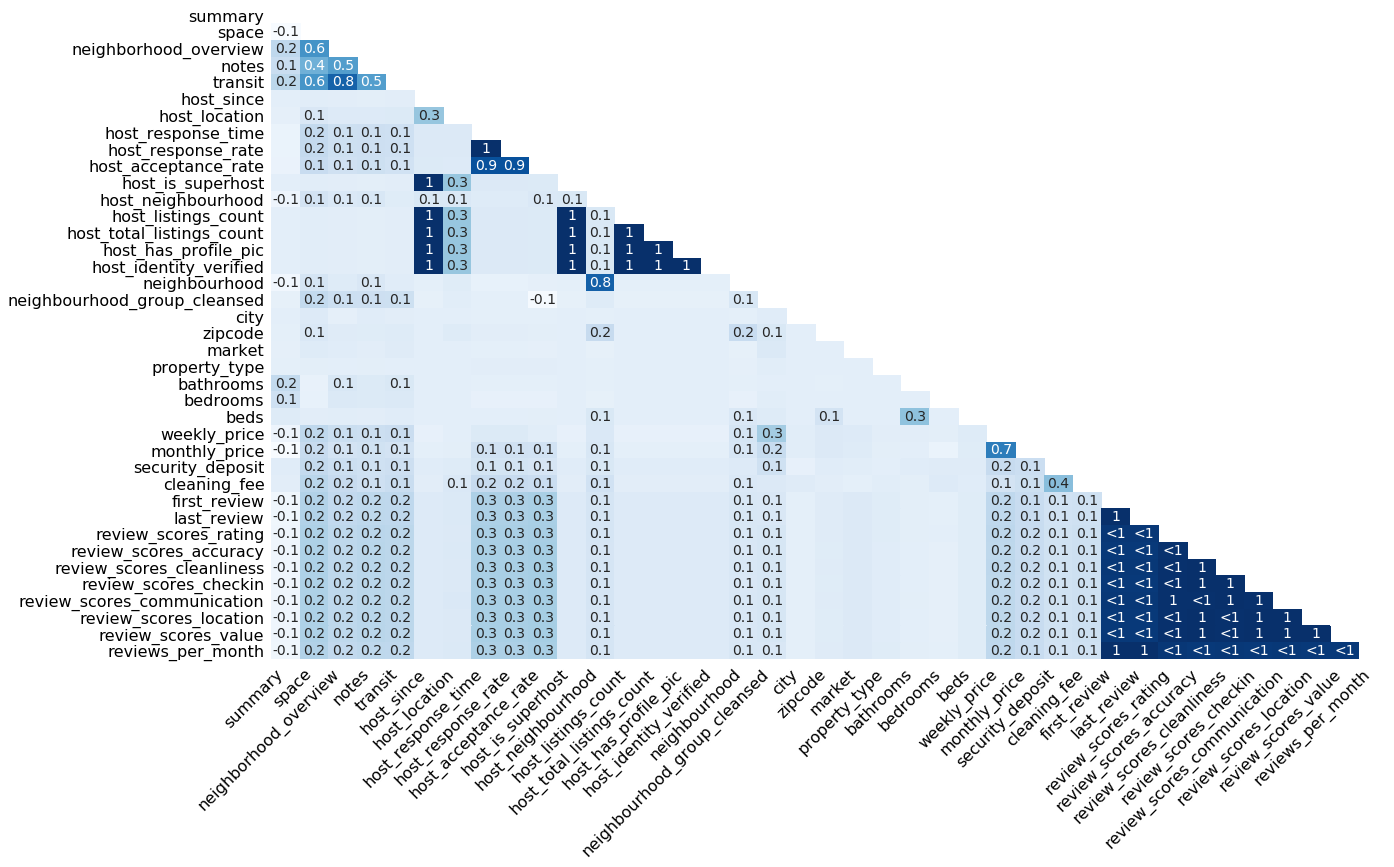

In [40]:
msno.heatmap(df, cmap = 'Blues')

How to read this plot? Let's pick some numbers. The first $1$ shows up at the correlation between `host_response_time` and `host_response_rate`. Whenever an observation of `host_response_time` is present in a case, an observation of `host_response_rate` is also present (and vice versa). Values close to $1$ or $-1$ are marked by $<1$/$>-1$. These relationships deserve special attention because, for example, at $<1$, a value is almost always present in both variables if it is present in one variable but in a few cases. The function does not print correlations $-.05 < r < .05$, which is the case for the majority of correlations in the plot above. That means there is no linear relationship in the missingness between two variables. We can see that, for example, `cleaning_fee` exhibits a low to zero correlation to other variables. It seems that `cleaning_fee` is also missing if various other details on the accomodation are missing, but this is not necessarily true.

## 4. dendrogram()

Compared to the heatmap, the dendrogram zooms out a bit and helps to reveal clusters of missing datas. That is, not only pairwise relationships but also relationships between groups of variables. The function relies on a [hierarchical clustering algorithm](http://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) to cluster the features based on their missingness measured by binary distance (although other cluster methods can be set as well). The closer features are in this graph (i.e. the earlier their lines meet), the stronger is their missingness. 

Again, it makes sense to exclude variables that have no/only missing values. If the distance of a feature to these features is of interest, they may be included. 

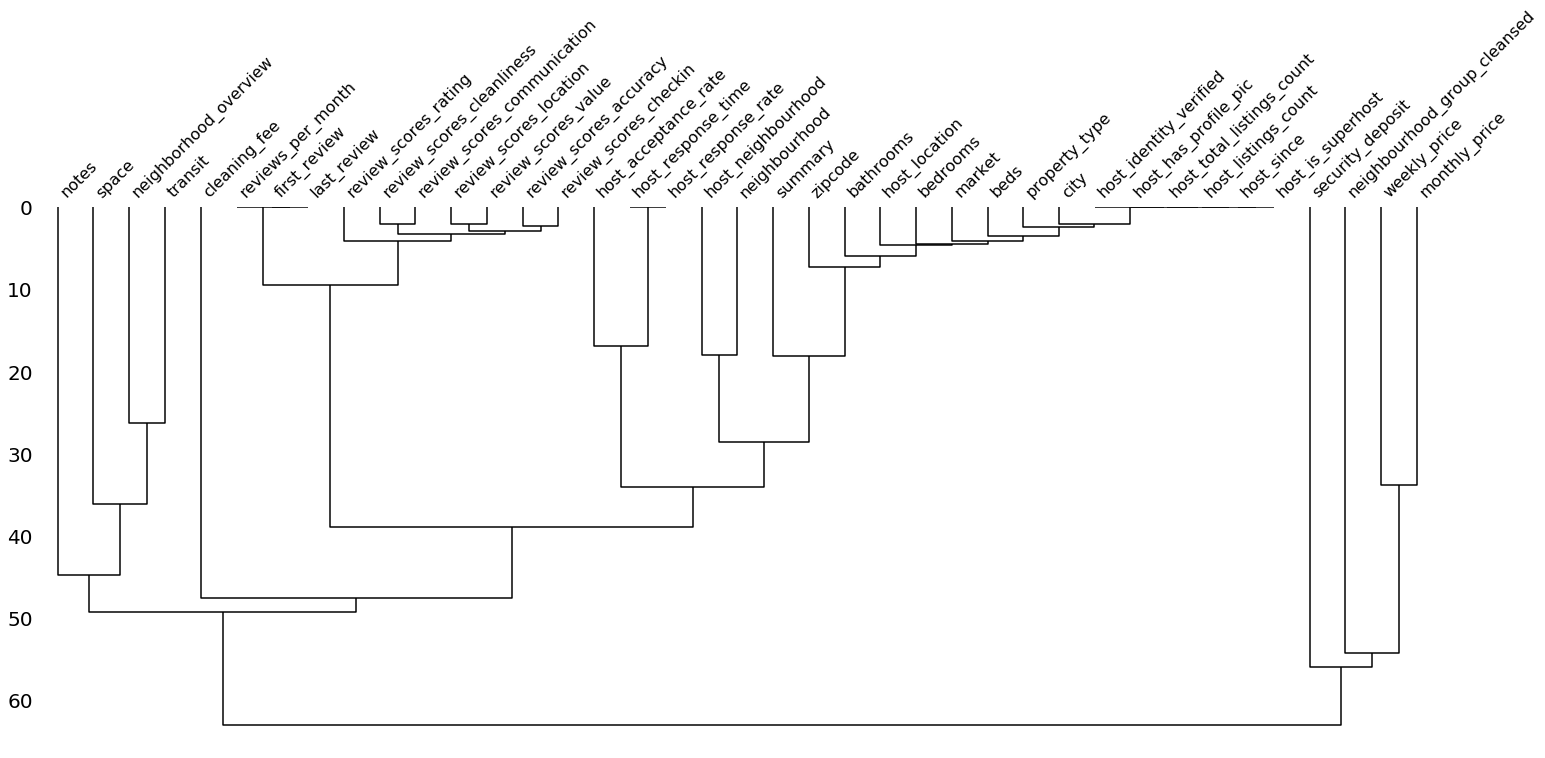

In [41]:
msno.dendrogram(df_miss)

As we can see, the variables that had a correlation of 1 in the plot above already meet at a distance of 0. We can see here that features regarding the review are strongly linked in their missingness – most of the time either all or none of these features are present. The same is true for some but not all host related feautures. If we examine cleaning_fee again, we see that it exhibits a large distance and, therefore, is weakly linked in it's missingness just as we saw in the heatmap. 

There is actually another plot function in this package, `geoplot()`, which generates a heatmap of nullity specific for  geographical data. But it seems like it has been deprecated by the author. If you do not work with geographical data, it is of no interest anyway.

We now had a look at the missing values of the data set. But this is only a single step in a machine learning pipeline. 

More to come in the next post!

<br>
<br>

Github repo for the package: [https://github.com/ResidentMario/missingno](https://github.com/ResidentMario/missingno)

<span style="font-size:12px;"><sup>1</sup></span> Bilogur, A. (2018). Missingno: a missing data visualization suite. *Journal of Open Source Software*, *3*(22), 547. [https://doi.org/10.21105/joss.00547](https://doi.org/10.21105/joss.00547) 